In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## Generator Model

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim + 10, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        gen_input = torch.cat((z, labels), 1)
        return self.main(gen_input)


## Discriminator Model

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + 10, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = labels.view(labels.size(0), -1)
        disc_input = torch.cat((x.view(x.size(0), -1), labels), 1)
        return self.main(disc_input)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
batch_size = 128
latent_dim = 100
num_epochs = 100

## Load Fashion MNIST dataset

In [15]:
torch.manual_seed(42)
np.random.seed(42)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15831693.73it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 261872.83it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4925307.73it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9168695.11it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Visualize the image

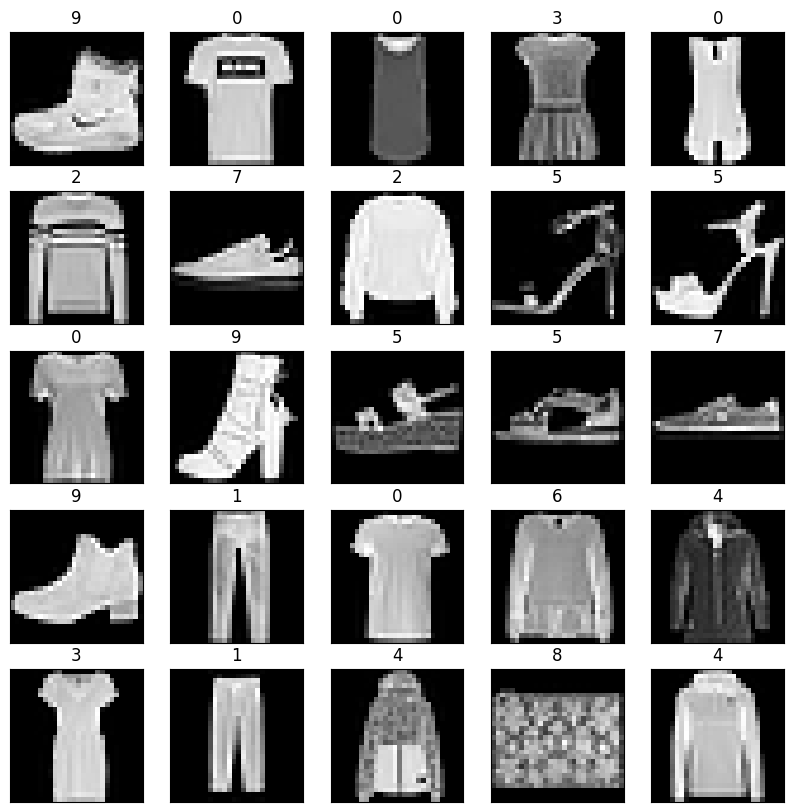

In [23]:
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

def show_images(images):
    fig = plt.figure(figsize=(10, 10))
    for idx in range(25):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx].numpy().squeeze(), cmap='gray')
        ax.set_title(str(train_dataset.targets[idx].item()))

fixed_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25, shuffle=False)
dataiter = iter(fixed_loader)
images, _ = next(dataiter)

show_images(images)
plt.show()

## Initialize networks

In [16]:
generator = Generator(latent_dim, 28*28).to(device)
discriminator = Discriminator(28*28).to(device)

In [17]:
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = torch.eye(10)[labels].to(device)

        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        z = torch.randn(images.size(0), latent_dim).to(device)

        gen_images = generator(z, labels)

        disc_optimizer.zero_grad()

        real_outputs = discriminator(images, labels)
        real_loss = criterion(real_outputs, real_labels)

        fake_outputs = discriminator(gen_images.detach(), labels)
        fake_loss = criterion(fake_outputs, fake_labels)

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        gen_optimizer.zero_grad()
        gen_outputs = discriminator(gen_images, labels)
        gen_loss = criterion(gen_outputs, real_labels)
        gen_loss.backward()
        gen_optimizer.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], "
                f"Step [{i}/{len(train_loader)}], "
                f"Gen Loss: {gen_loss.item():.4f}, "
                f"Disc Loss: {disc_loss.item():.4f}"
            )

### Save the trained models

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")